**Table of contents**<a id='toc0_'></a>    
- [MNIST digit classification problem — SVM](#toc1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[MNIST digit classification problem — SVM](#toc0_)

Attempting the digit classification problem with SVM classifier.


In [5]:
import os
import pathlib
import pickle

import mlflow
import mlflow.sklearn
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.model_selection import train_test_split

## Parameters and constants

In [6]:
TRAIN_SET_SIZE = 50_000
SPLIT_SEED = 123
EXPERIMENT_DIR = pathlib.Path('/data/kaggle/mnist')

## Setup mlflow for experiment tracking

In [14]:
mlflow.set_tracking_uri("https://mlflow.tenzing.shkhr.ovh")
# experiment_id = mlflow.create_experiment('mnist-digits', artifact_location='s3://mlflow/mnist')
experiment = mlflow.set_experiment('mnist-digits')
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'https://minio-api.tenzing.shkhr.ovh'

## Load the dataset

Load the MNIST dataset and generate the train, validation and test splits and view a few random training samples.

In [8]:
dataset = load_dataset('mnist')
train_set, validation_set = train_test_split(dataset['train'], train_size=TRAIN_SET_SIZE, random_state=SPLIT_SEED)
test_set = dataset['test']

Found cached dataset mnist (/home/shikhar/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)
100%|██████████| 2/2 [00:00<00:00, 704.93it/s]


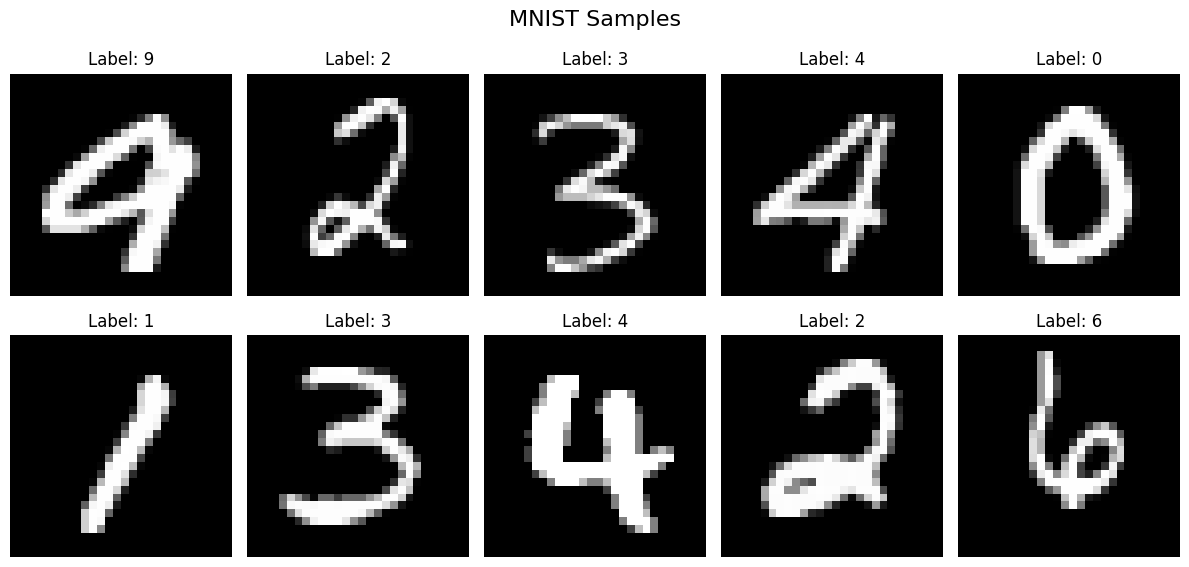

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('MNIST Samples', fontsize=16)

for i, ax in enumerate(axes.flatten()):
    sample_idx = np.random.randint(0, len(train_set['image']))
    sample_image, sample_label = train_set['image'][sample_idx], train_set['label'][sample_idx]

    ax.imshow(sample_image, cmap='gray')
    ax.set_title(f'Label: {sample_label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Model 1: Sklearn's SVM classifier, default parameters

In [10]:
from sklearn import svm

In [16]:
%%time
with mlflow.start_run(run_name='svm-sklearn-default-params', description='SVM classifier using sklearn\'s default params.', experiment_id=experiment.experiment_id) as run:
    clf = svm.SVC()

    # Reshape the training set.
    X_train = np.array([np.array(img).reshape(784,) for img in train_set['image']])
    y_train = np.array(train_set['label'])

    X_validation = np.array([np.array(img).reshape(784,) for img in validation_set['image']])
    y_validation = np.array(validation_set['label'])

    # Fit classifier.
    clf.fit(X_train, y_train)

    model_path = EXPERIMENT_DIR / run.info.run_id / 'classifier.pkl'
    model_path.parent.mkdir(exist_ok=True)
    # Save classifier to disk.
    with open(model_path, 'wb') as model_file:
        pickle.dump(clf, model_file)

    mlflow.log_artifact(model_path)

    # Evaluate on train and validation set.
    train_predictions = clf.predict(X_train)
    train_accuracy = (train_predictions == y_train).mean()

    validation_predictions = clf.predict(X_validation)
    validation_accuracy = (validation_predictions == y_validation).mean()

    mlflow.log_metric('train_accuracy', train_accuracy)
    mlflow.log_metric('validation_accuracy', validation_accuracy)

CPU times: user 7min 6s, sys: 600 ms, total: 7min 6s
Wall time: 7min 10s
